# Focal Plane Distortion Analysis

In [1]:
%matplotlib inline

In [2]:
import datetime
import os
import pathlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import matplotlib.dates

In [5]:
import numpy.polynomial

In [6]:
import scipy.optimize

In [7]:
import pandas as pd

In [8]:
import desimeter.transform.pos2ptl
import desimeter.transform.xy2qs
import desimeter.transform.zhaoburge

In [9]:
# Waiting for https://github.com/desihub/desiconda/issues/52 until this runs in a desiconda env
import fpoffline.io
import fpoffline.array
from fpoffline.scripts.endofnight import ptl2fp_nominal

In [10]:
NERSC = False

In [11]:
SCRATCH = pathlib.Path(os.getenv('SCRATCH')) if NERSC else pathlib.Path('/Users/dkirkby/Downloads')
assert SCRATCH.exists()

Read a single end-of-night file to lookup some static data:

In [12]:
kwargs = dict(verbose=False)
if not NERSC:
    kwargs['parent_dir'] = SCRATCH
S, M = fpoffline.io.load_endofnight(20220101, **kwargs)

Build dictionaries to map between pos_id and location:

In [13]:
pos2loc = {row['DEVICE_ID']: row['LOCATION'] for row in S}
loc2pos = {row['LOCATION']: row['DEVICE_ID'] for row in S}

Look up the offset_x,y and r1,r2 calibration params for each robot, which are in "flat" space:

In [14]:
def get_calib_by_loc():
    offsets_by_loc = np.zeros((9600, 2))
    r12s_by_loc = np.zeros((9600, 3))
    for row in S.filled():
        # Lookup the calibration offset params, which are in "flat" space.
        x_flat, y_flat = row['OFFSET_X'], row['OFFSET_Y']
        # Convert from flat to petal space.
        x_ptl, y_ptl = desimeter.transform.pos2ptl.flat2ptl(x_flat, y_flat)
        # Rotate to FP space with nominal petal alignment.
        loc = row['LOCATION']
        x_fp, y_fp = ptl2fp_nominal(np.array([x_ptl]), np.array([y_ptl]), np.array([loc // 1000]))
        # Lookup the arm lengths.
        r1, r2 = row['LENGTH_R1'], row['LENGTH_R2']
        # Lookup the conversion from r (PTL) to s (FLAT).
        r = np.hypot(x_ptl, y_ptl)
        dr = 0.1
        if r < 420:
            ds = desimeter.transform.xy2qs.r2s(r + dr / 2) - desimeter.transform.xy2qs.r2s(r - dr / 2)
        else:
            ds = 1.
        # Save by location.
        offsets_by_loc[loc] = x_fp[0], y_fp[0]
        r12s_by_loc[loc] = r1, r2, ds / dr
    return offsets_by_loc, r12s_by_loc

offsets_by_loc, r12s_by_loc = get_calib_by_loc()

The load_nights functionality is now packaged as a standalone cmd-line script, but keep this here to document what it does:

In [15]:
def nightrange(first, last):
    """Loop over nights YYYYMMDD in [first, last]."""
    one_day = datetime.timedelta(days=1)
    begin, end = [datetime.datetime.strptime(str(night), "%Y%m%d") for night in (first, last)]
    date = begin
    while date <= end:
        yield int(date.strftime("%Y%m%d"))
        date += one_day

In [16]:
def load_nights(start, stop):
    moves = [ ]
    for night in nightrange(start, stop):
        try:
            S, M = fpoffline.io.load_endofnight(night, verbose=False)
            # Keep only non-blocked blind moves for enabled robots.
            sel = M.req_x.notna() & M.obs_x.notna() & (M.exposure_iter == 0) & M.ctrl_enabled & ~M.blocked
            # Keep only selected columns to save space.
            M = pd.DataFrame(M[sel][['location','exposure_id','ptl_x','ptl_y','req_x','req_y']])
            # Replace the measured (x,y) with the residuals (dx,dy).
            M['dx'] = 1e3 * (M.ptl_x - M.req_x)
            M['dy'] = 1e3 * (M.ptl_y - M.req_y)
            M = M.drop(columns=['ptl_x', 'ptl_y'])
            # Subtract the nominal robot centers from the requested (x,y).
            offsets = offsets_by_loc[M.location]
            M['req_x'] -= offsets[:,0]
            M['req_y'] -= offsets[:,1]
            moves.append(M)
            print(f'Loaded {len(moves[-1])} moves for {night}')
        except Exception as e:
            #raise e
            print(f'Unable to read {night}')
    return pd.concat(moves, axis='index', ignore_index=True)

`load_nights` takes ~14 mins to run, so save the results to a feather file using the next 2 lines, then
comment them out and just use the third line to read them. You will need to `conda install pyarrow` in your environment for feather support.

In [17]:
#%time All = load_nights(start=20211101, stop=20220613)

In [18]:
def merge():
    F1 = pd.read_feather(SCRATCH / 'SepDec21c.feather')
    F2 = pd.read_feather(SCRATCH / 'JanJun22c.feather')
    F3 = pd.read_feather(SCRATCH / 'AugOct22c.feather')
    All = pd.concat([F1,F2,F3], axis='index', ignore_index=True)
    All.to_feather(SCRATCH / 'All-correction.feather')
    
#merge()

In [19]:
All = pd.read_feather(SCRATCH / 'All.feather')

In [20]:
AllCorr = pd.read_feather(SCRATCH / 'All-correction.feather')

In [21]:
all_exps = np.unique(All.exposure_id)
nexps = len(all_exps)
nrobots = len(np.unique(All.location))
print(f'Loaded {len(All)} moves for {nrobots} robots (avg {len(All) / nrobots:.1f} moves/robot) and {nexps} exposures.')

Loaded 27157227 moves for 4301 robots (avg 6314.2 moves/robot) and 6381 exposures.


Plot the median residuals for each robot.  These should mostly be due to solid-body misalignments (offset and rotation) of each petal:

In [22]:
def quiverFP(locs, dx, dy, ref=100, size=10, color='k', ax=None):
    # ref is arrow length in microns displayed as 50mm in the focal plane.
    FP = fpoffline.array.DeviceArray()
    x, y = FP.xy(locs)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(size, size))
        ax.axis('off')
        ax.set(xlim=(-420, 420), ylim=(-420, 420), aspect=1)
    Q = ax.quiver(x, y, dx, dy, angles='xy', scale=ref/50, scale_units='xy',
                  headwidth=5, headlength=6, width=0.001, color=color)
    ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref}μm', labelpos='S')
    return ax

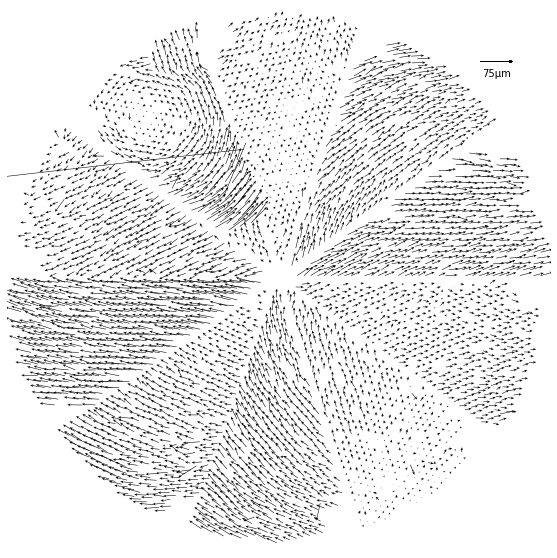

In [23]:
def plot_all(M=All, median=True, ref=75):

    # Calculate median obs-req residuals per device.
    bypos = M.groupby(by='location')
    if median:
        avg = bypos.median()
    else:
        avg = bypos.mean()

    locs = np.array(avg.index, int)
    dx, dy = np.array(avg.dx), np.array(avg.dy)
    ax = quiverFP(locs, dx, dy, ref=ref)
    
plot_all(All)

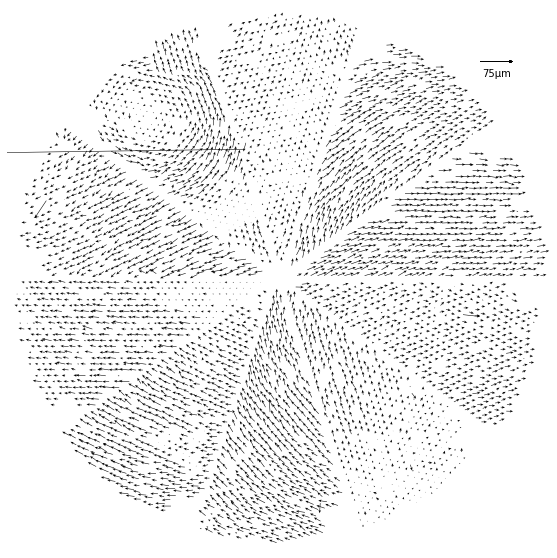

In [24]:
plot_all(AllCorr)

Plot the co-variance of residuals over exposures for each robot:

58.72510978239964 362.5452029681584


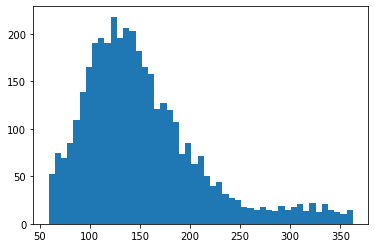

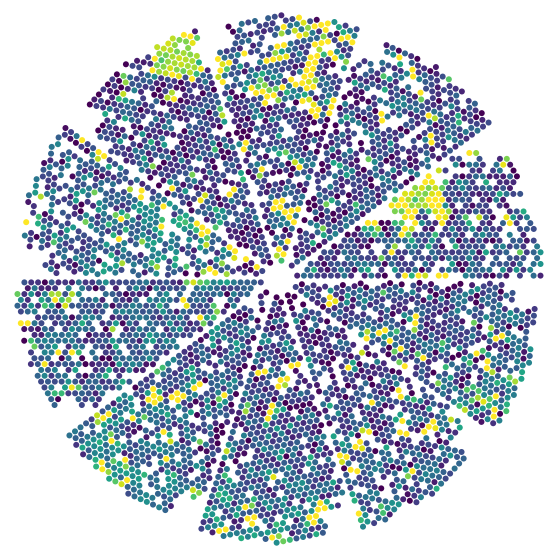

In [43]:
def plot_covar(M=All, what='std', size=10):
    
    # Calculate median obs-req residuals per device.
    bypos = M[['location','dx','dy']].groupby(by='location')
    std0 = bypos.std()
    locs = np.array(std0.index, int)
    nloc = len(locs)
    std = np.zeros(nloc)
    
    cov = bypos.cov()
    sig = np.zeros((nloc, 2))
    rho = np.zeros(nloc)
    for i, loc in enumerate(locs):
        C = np.array(cov.loc[loc])
        std[i] = np.sqrt(C[0,0] + C[1,1])
        sig[i] = np.sqrt(np.diag(C))
        rho[i] = C[0,1] / (sig[i,0] * sig[i,1])
    
    X = dict(std=std, std0=std0, rho=rho)[what]
    vmin, vmax = np.percentile(X, (5, 95))
    print(vmin, vmax)
    plt.hist(X, bins=np.linspace(vmin, vmax, 50))
    plt.show()

    FP = fpoffline.array.DeviceArray()
    x, y = FP.xy(locs)
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    ax.axis('off')
    ax.set(xlim=(-420, 420), ylim=(-420, 420), aspect=1)
    S = ax.scatter(x, y, c=X, lw=0, vmin=vmin, vmax=vmax)

cov = plot_covar()

-0.7037850502577674 0.7110398769785301


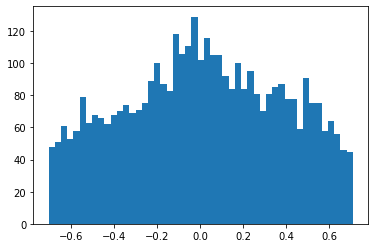

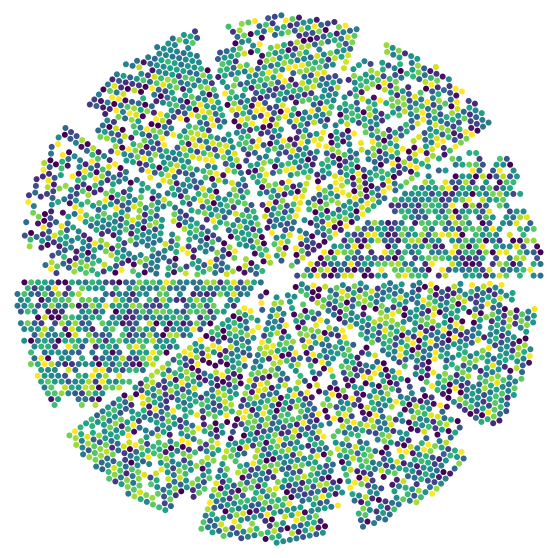

In [44]:
cov = plot_covar(what='rho')

Fit for 5 rigid-body parameters per petal to correct for any misalignments:

In [37]:
def get_outliers(x, nsig=4):
    # Calculate the median and median-absolute deviation (MAD)
    med = np.median(x)
    MAD = np.median(np.abs(x - med))
    # Estimate the equivalent Gaussian sigma
    sigma = 1.4826 * MAD
    # Cut to identify outliers.
    outlier_cut = med + nsig * sigma
    return x >= outlier_cut

In [65]:
def fit_petals(M, outlier_nsig=3):
    
    def model_full(params, x, y):
        offset_x, offset_y, rot_x, rot_y, rot_phi = params
        C, S = np.cos(rot_phi), np.sin(rot_phi)
        pred_dx = 1e3 * (rot_x + C * (x - rot_x) - S * (y - rot_y) - x) + offset_x
        pred_dy = 1e3 * (rot_y + S * (x - rot_x) + C * (y - rot_y) - y) + offset_y
        return pred_dx, pred_dy

    def model_rotation(params, x, y):
        rot_x, rot_y, rot_phi = params
        C, S = np.cos(rot_phi), np.sin(rot_phi)
        pred_dx = 1e3 * (rot_x + C * (x - rot_x) - S * (y - rot_y) - x)
        pred_dy = 1e3 * (rot_y + S * (x - rot_x) + C * (y - rot_y) - y)
        return pred_dx, pred_dy

    def model_offset(params, x, y):
        offset_x, offset_y = params
        pred_dx = offset_x * np.ones_like(x)
        pred_dy = offset_y * np.ones_like(y)
        return pred_dx, pred_dy

    def chisq(params, x, y, dx, dy, model, rot_xy_sigma=None):
        pred_dx, pred_dy = model(params, x, y)
        fun = np.sum((dx - pred_dx) ** 2) + np.sum((dy - pred_dy) ** 2)
        if rot_xy_sigma:
            x0, y0 = x.mean(), y.mean()
            rot_x, rot_y = params[2:4]
            nlp = ((rot_x - x0) ** 2 + (rot_y - y0) ** 2) / (2 * rot_xy_sigma ** 2)
            fun += nlp
        return fun
    
    params = [ ]
    bypos = M.groupby(by='location')
    avg = bypos.median()
    for petal_loc in range(10):    
        sel = avg.index // 1000 == petal_loc
        petal = avg[sel]
        locs = np.array(petal.index, int)
        offsets = offsets_by_loc[locs]
        x = offsets[:,0]
        y = offsets[:,1]
        dx = np.array(petal.dx)
        dy = np.array(petal.dy)
        
        # do an initial 2-param fit to the offsets only.
        initial = [ 0., 0., x.mean(), y.mean(), 0. ]
        fit_offset = scipy.optimize.minimize(chisq, initial[:2], args=(x, y, dx, dy, model_offset), method='Nelder-Mead')
        assert fit_offset.success

        # fit the full 5-param model using initial offsets from the 2-param fit.
        initial[:2] = fit_offset.x
        sigma = 100
        fit_full = scipy.optimize.minimize(chisq, initial, args=(x, y, dx, dy, model_full, sigma), method='Nelder-Mead')
        assert fit_full.success
        
        # identify "core" robots whose fit residuals are not outliers.
        fit_dx, fit_dy = model_full(fit_full.x, x, y)
        residual = np.hypot(dx - fit_dx, dy - fit_dy)
        core = ~get_outliers(residual, outlier_nsig)
        
        # refine the 5-param model with outliers removed.
        initial[:] = fit_full.x
        fit_full_core = scipy.optimize.minimize(
            chisq, initial, args=(x[core], y[core], dx[core], dy[core], model_full, sigma), method='Nelder-Mead')
        assert fit_full_core.success

        # Calculate the best-fit model for all (core + outlier) robots.
        fit_dx, fit_dy = model_full(fit_full_core.x, x, y)
        
        # Save the best-fit model and residuals for all robots.
        avg.loc[sel, 'fit_dx'] = fit_dx
        avg.loc[sel, 'fit_dy'] = fit_dy
        avg.loc[sel, 'resid_dx'] = dx - fit_dx
        avg.loc[sel, 'resid_dy'] = dy - fit_dy
        avg.loc[sel, 'core'] = core
        params.append(fit_full_core.x)
        
    return avg, np.array(params)

fit_results, fit_params = fit_petals(All)

In [359]:
fit_results_corr, fit_params_corr = fit_petals(AllCorr)

In [42]:
def plot_fit(fit_results, fit_params, what='model', centers=False, ref=100, save=None):

    locs = np.array(fit_results.index, int)
    petal_locs = locs // 1000
    core = np.array(fit_results.core, bool)
    if what == 'model':
        dx, dy = np.array(fit_results.fit_dx), np.array(fit_results.fit_dy)
    elif what == 'offset':
        dx, dy = fit_params[petal_locs, :2].T
    elif what == 'rotate':
        rot_x, rot_y = fit_params[petal_locs, 2:4].T
        C, S = np.cos(fit_params[:,4]), np.sin(fit_params[:,4])
        offsets = offsets_by_loc[locs]
        x = offsets[:,0]
        y = offsets[:,1]
        dx = 1e3 * (rot_x + C[petal_locs] * (x - rot_x) - S[petal_locs] * (y - rot_y) - x)
        dy = 1e3 * (rot_y + S[petal_locs] * (x - rot_x) + C[petal_locs] * (y - rot_y) - y)
    elif what == 'residuals':
        dx, dy = np.array(fit_results.resid_dx), np.array(fit_results.resid_dy)
    elif what == 'data':
        dx, dy = np.array(fit_results.dx), np.array(fit_results.dy)
    else:
        print(f'Invalid what: "{what}".  Expected model/residuals/data.')
    
    # Plot (dx,dy) for each robot, using red for the outliers not used in the fit.
    ax = quiverFP(locs[~core], dx[~core], dy[~core], ref=ref, color='r')
    quiverFP(locs[core], dx[core], dy[core], ref=ref, color='k', ax=ax)
    ax.text(0.9, 0.92, what, fontsize=14, ha='center', transform=ax.transAxes)
    
    if centers:
        # Show the best-fit rotation centers for each petal in blue.
        ax.plot(fit_params[:,2], fit_params[:,3], 'bo')
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

Show the median positioning residuals (observed - target petal coords) with outliers highlighted in red:

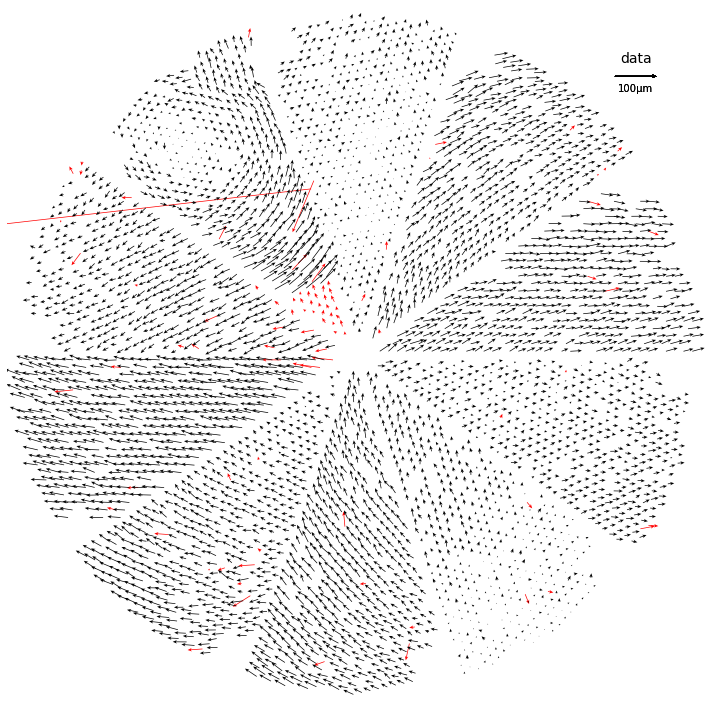

In [67]:
plot_fit(fit_results, fit_params, 'data', save='fit-data.png')

The 5-parameter petal-misalignment model first rotates each petal about a fitted center point (3 params), then offsets it by a constant amount (2 params). Plot just the best-fit rotation first, with the fitted rotation centers shown as blue points:

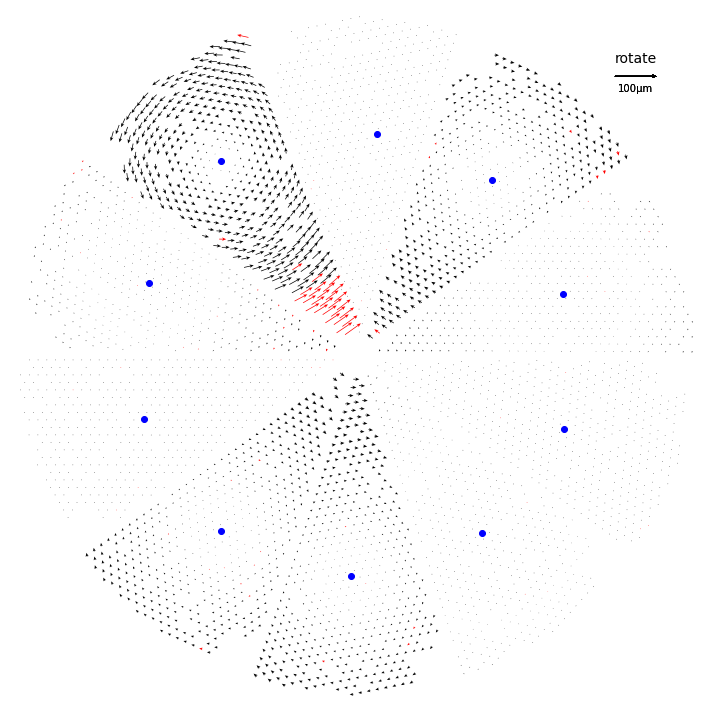

In [68]:
plot_fit(fit_results, fit_params, 'rotate', True, save='fit-rotate.png')

Next, show just the best-fit constant offsets per petal:

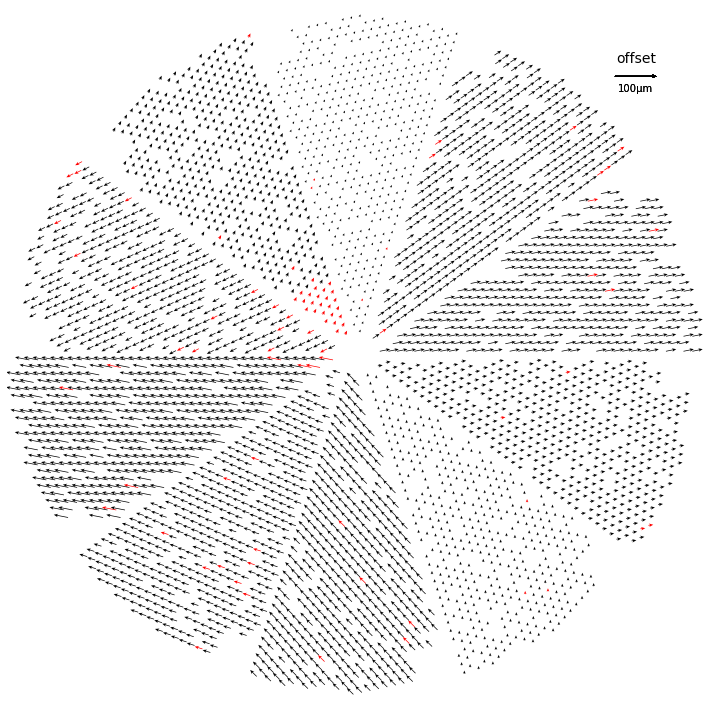

In [69]:
plot_fit(fit_results, fit_params, 'offset', save='fit-offset.png')

Finally, show the combined rotate & offset best-fit model:

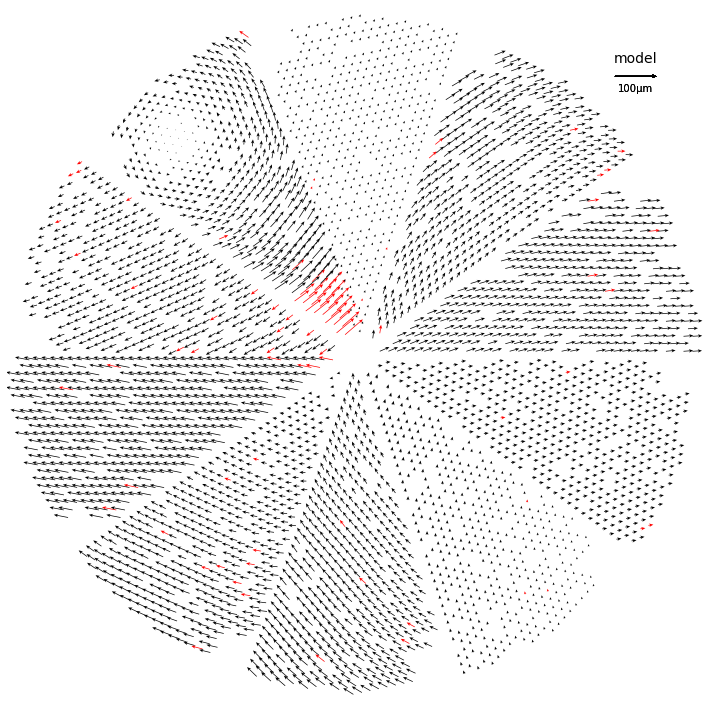

In [70]:
plot_fit(fit_results, fit_params, 'model', save='fit-model.png')

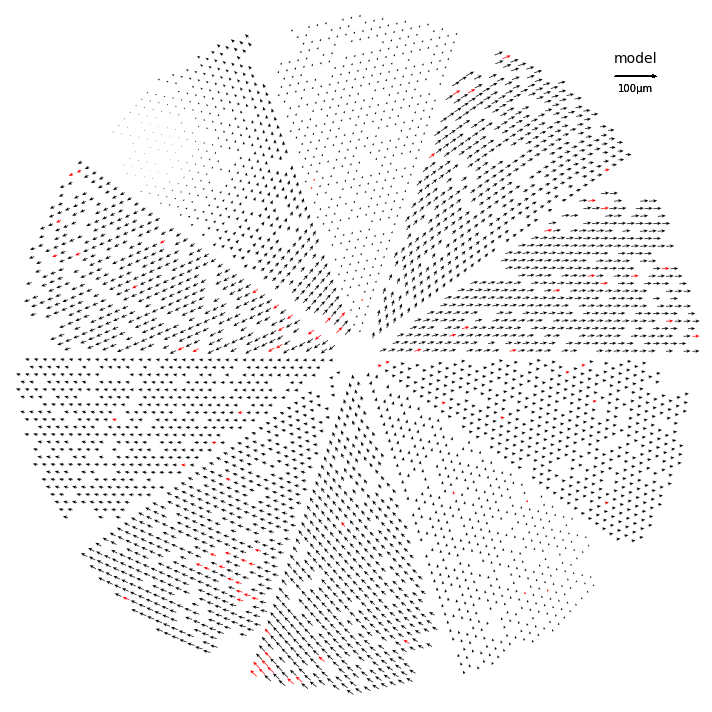

In [362]:
plot_fit(fit_results_corr, fit_params_corr, 'model')

and the resulting fit residuals, which are used to identify and ignore the outliers shown in red. Note the larger arrow scale (25 vs 100um):

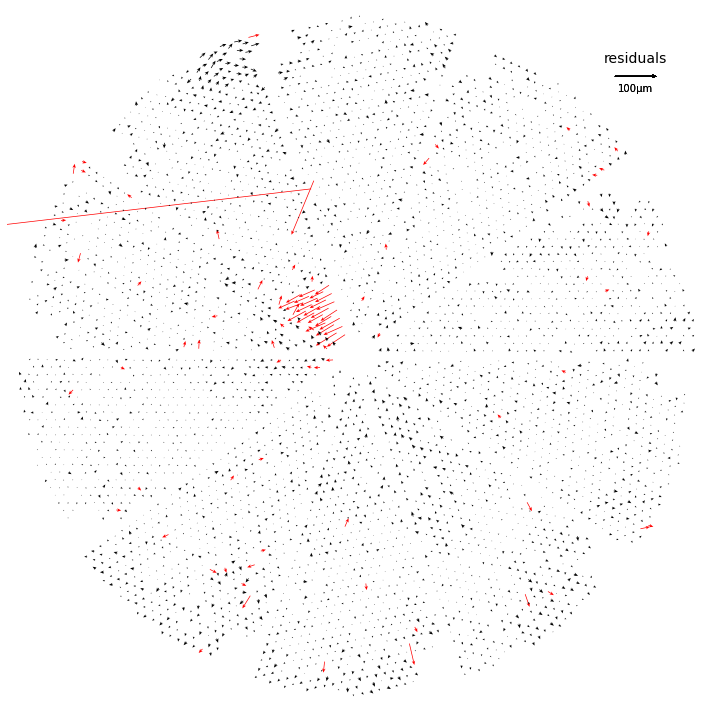

In [71]:
plot_fit(fit_results, fit_params, 'residuals', ref=100, save='fit-residuals.png')

Identify robots with large residuals after subtracting the 5-parameter best fits:

In [72]:
def list_outliers(A=fit_results, n=10, petals=range(10)):
    
    petals = np.atleast_1d(petals)
    resid_dr = np.hypot(A.resid_dx, A.resid_dy)
    isort = np.argsort(resid_dr)[::-1]
    for idx in isort:
        row = A.iloc[idx]
        loc = A.index[idx]
        if loc // 1000 not in petals:
            continue
        print(f'{loc2pos[loc]} loc={loc} resid=({row.resid_dx:.2f},{row.resid_dy:.2f})um core={row.core}')
        n -= 1
        if n == 0:
            break

List the 10 largest outliers over the whole focal plane (`core=False` corresponds to the red arrows above):

In [73]:
list_outliers()

M02055 loc=5148 resid=(-2448.71,-285.91)um core=False
M05723 loc=5161 resid=(-53.83,-130.05)um core=False
M06041 loc=6002 resid=(-49.89,-30.59)um core=False
M06047 loc=6003 resid=(-48.81,-27.42)um core=False
M05982 loc=434 resid=(11.98,-51.58)um core=False
M06039 loc=6000 resid=(-43.79,-28.86)um core=False
M08333 loc=6007 resid=(-47.99,-20.76)um core=False
M05711 loc=6004 resid=(-43.52,-26.50)um core=False
M06169 loc=6020 resid=(-44.00,-24.10)um core=False
M06037 loc=6001 resid=(-45.47,-20.27)um core=False


Identify robots in P9 that are likely affected by the C3 divot:

In [74]:
list_outliers(petals=9)

M02113 loc=9349 resid=(-19.11,-30.53)um core=False
M07913 loc=9271 resid=(-18.10,-6.25)um core=False
M01556 loc=9323 resid=(16.43,-8.42)um core=False
M07442 loc=9279 resid=(-15.14,-6.98)um core=False
M02121 loc=9127 resid=(7.97,11.49)um core=False
M01752 loc=9524 resid=(-9.04,-9.71)um core=False
M01950 loc=9083 resid=(12.16,4.28)um core=False
M07754 loc=9327 resid=(11.49,-5.74)um core=False
M07908 loc=9236 resid=(12.13,3.46)um core=False
M07497 loc=9305 resid=(3.99,-11.89)um core=False


Plot residuals for a single exposure with the petal-alignment fit subtracted:

In [188]:
def plot_exp(M=All, expid=None, idx=0, ref=100, fit_results=fit_results, outlier_nsig=4, subtract='fit',
             smoothing=None, subtract_exp_median=True, verbose=True):
    
    expid = expid or all_exps[idx]
    M = M[M.exposure_id == expid]
    locs = np.array(M.location)
    x, y = np.array(M.req_x), np.array(M.req_y)
    dx, dy = np.array(M.dx), np.array(M.dy)
    # Subtract the median or fit if requested    
    if subtract == 'median':
        dx -= fit_results.dx.loc[locs]
        dy -= fit_results.dy.loc[locs]
    elif subtract == 'fit':
        dx -= fit_results.fit_dx.loc[locs]
        dy -= fit_results.fit_dy.loc[locs]
    # Reject residual outliers.
    dr = np.hypot(dx, dy)
    core = ~get_outliers(dr, outlier_nsig)
    if verbose:
        print(f'Ignoring {np.count_nonzero(~core)} / {len(core)} outlier moves')
    locs = locs[core]
    x, y = x[core], y[core]
    dx, dy = dx[core], dy[core]
    # Subtract median for this exposure.
    if subtract_exp_median:
        dx0, dy0 = np.median(dx), np.median(dy)
        if(verbose):
            print(f'Expid {expid} median (dx,dy) = ({dx0:.1f},{dy0:.1f}) um')
        dx -= dx0
        dy -= dy0
    # Apply Gaussian smoothing if requested
    if smoothing:
        x2, y2 = x.reshape(-1, 1), y.reshape(-1, 1)
        W = np.exp(-0.5 * ((x - x2) ** 2 + (y - y2) ** 2) / smoothing ** 2)
        W /= W.sum(axis=1, keepdims=True)
        dx = W.dot(dx)
        dy = W.dot(dy)
    
    ax = quiverFP(locs, dx, dy, ref=ref)

Ignoring 8 / 4261 outlier moves


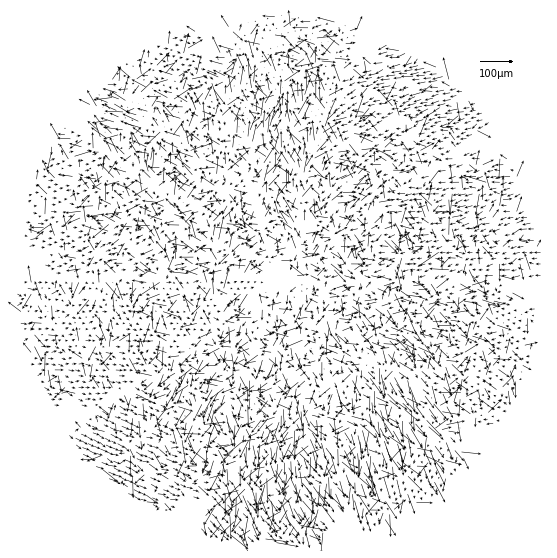

In [365]:
plot_exp(M=AllCorr, idx=238, smoothing=0, ref=100, subtract='fit', subtract_exp_median=False, fit_results=fit_results_corr)

Ignoring 53 / 4288 outlier moves


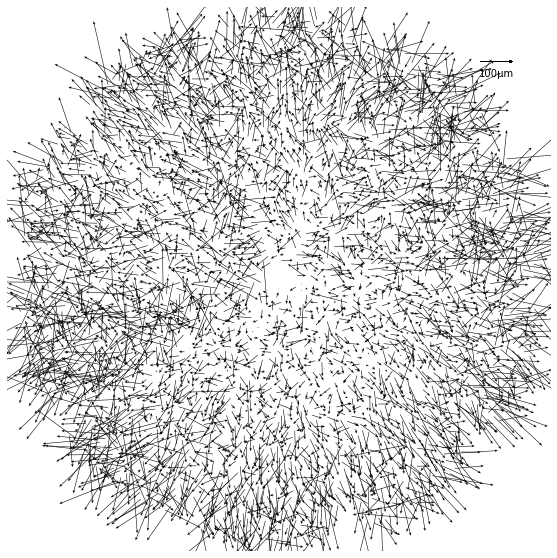

In [366]:
plot_exp(idx=238, smoothing=0, ref=100, subtract='fit', subtract_exp_median=False)

Ignoring 41 / 4235 outlier moves


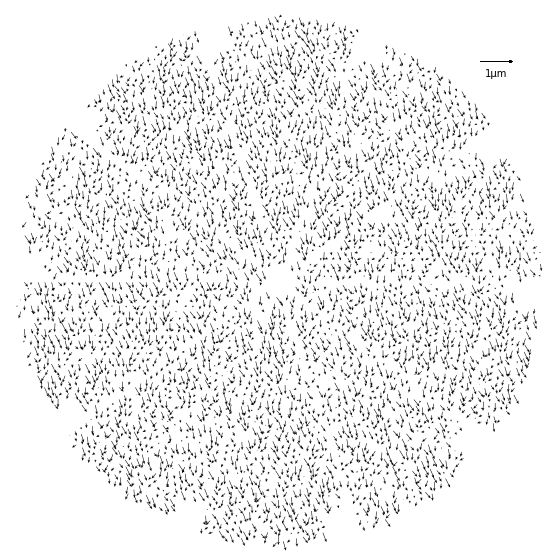

In [177]:
plot_exp(idx=6015, smoothing=10, ref=1)

Partition the space explored by each fiber into a 2D grid of cells, and assign each move to a cell based on its requested (x,y):

In [242]:
def addbin(M, nbins=15, rmax=6):

    bins = np.linspace(-rmax, +rmax, nbins+1)
    xbin = np.digitize(M.req_x, bins)
    ybin = np.digitize(M.req_y, bins)
    M['bin'] = (nbins + 2) * ybin + xbin
    
addbin(All)

In [370]:
addbin(AllCorr)

Extract binned or unbinned data (x,y,dx,dy) for a single robot:

**Extract binned counts and estimate uncertainties on each binned (dx,dy) for fitting**

In [243]:
def get_data(pos_id, M=All, fit_results=fit_results, outlier_nsig=4, subtract='fit',
             binned=True, min_count=16, summary='mean', sig2d=10, verbose=True):
    
    # Restrict to the selected robot
    loc = pos2loc[pos_id]
    sel = (M.location == loc)
    M = M[sel]
    # Extract the unbinned values.
    x, y = M.req_x, M.req_y
    dx, dy = M.dx, M.dy
    # Subtract the median or fit if requested
    info = fit_results.loc[loc]
    if subtract == 'median':
        dx -= info.dx
        dy -= info.dy
    elif subtract == 'fit':
        dx -= info.fit_dx
        dy -= info.fit_dy
    # Reject residual outliers.
    dr = np.hypot(dx, dy)
    core = ~get_outliers(dr, outlier_nsig)
    if verbose:
        print(f'Ignoring {np.count_nonzero(~core)} / {len(core)} outlier moves')
    x, y = x[core], y[core]
    dx, dy = dx[core], dy[core]
    if binned:
        # Only use bins with at least min_count moves.
        counts = np.bincount(M.bin[core])
        good_bin = np.where(counts >= min_count)
        rejected = np.count_nonzero((counts > 0) & (counts < min_count))
        if verbose:
            print(f'Ignoring {rejected} bins with <{min_count} non-outlier moves')
        M = M[np.isin(M.bin, good_bin) & core]
        bybin = M.groupby(by='bin').agg({
            'location': 'sum', 'req_x': 'mean', 'req_y': 'mean', 'dx': summary, 'dy': summary})
        x, y = bybin.req_x, bybin.req_y
        dx, dy = bybin.dx, bybin.dy
        n = np.array(bybin.location)
        #assert np.all(n >= min_count)
        wgt = n / sig2d ** 2
    else:
        wgt = np.ones(len(x)) / sig2d ** 2

    # Rotate to undo the nominal petal alignment.
    petal_loc = loc // 1000
    phi = (petal_loc - 3) * np.pi / 5
    C, S = np.cos(phi), np.sin(phi)
    x, y = C * x + S * y, -S * x + C * y
    dx, dy = C * dx + S * dy, -S * dx + C * dy
    
    # Correct for ds/dr in the radial direction.
    # ...

    return np.asarray(x), np.asarray(y), np.asarray(dx), np.asarray(dy), wgt

Fit (x,y,dx,dy) for a single robot to a model of calibration errors (dx0,dy0,dr1,dr2):

**How to handle (x,y) that are not reachable for (r1,r2)?**

In [49]:
def xy2tp(x, y, r1, r2, x0, y0):
    r12 = r1 + r2
    r1sq = r1 ** 2
    r2sq = r2 ** 2
    phi = np.arctan2(y - y0, x - x0)
    rsq = (x - x0) ** 2 +  (y - y0) ** 2
    r = np.sqrt(rsq)
    s = (rsq - r2sq + r1sq) / (2 * (r + 1e-9))
    beta = np.arccos(s / r1)
    #a = np.sqrt(r1sq - s * s)
    #beta = np.arctan2(a, s)
    T = phi - beta
    P = np.arccos((rsq - r1sq - r2sq) / (2 * r1 * r2))
    return T, P

In [50]:
def tp2xp(T, P, r1, r2, x0, y0):
    x = x0 + r1 * np.cos(T) + r2 * np.cos(T + P)
    y = y0 + r1 * np.sin(T) + r2 * np.sin(T + P)
    return x, y

In [51]:
def calib_errors_model(x, y, dx0, dy0, dr1, dr2, r1, r2):
    # Calculate angles using the assumed calibration parameters.
    T, P = xy2tp(x, y, r1, r2, 0., 0.,)
    # Calculate actual positions for the specified calibration errors in microns.
    x2, y2 = tp2xp(T, P, r1 + 1e-3 * dr1, r2 + 1e-3 * dr2, 1e-3 * dx0, 1e-3 * dy0)
    # Return residuals in microns
    return 1e3 * (x2 - x), 1e3 * (y2 - y)

In [52]:
def fit_calib_errors(pos_id, x, y, dx, dy, wgt):

    loc = pos2loc[pos_id]
    r1, r2, _ = r12s_by_loc[loc]
    
    def fun(params):
        dx0, dy0, dr1, dr2 = params
        dx_pred, dy_pred = calib_errors_model(x, y, dx0, dy0, dr1, dr2, r1, r2)
        nll = 0.5 * np.sum(wgt * ((dx_pred - dx) ** 2 + (dy_pred - dy) ** 2))
        # Add Gaussian priors
        nlp = 0.5 * (np.hypot(dx0, dy0) - 100) ** 2 + 0.5 * (np.hypot(dr1, dr2) - 25) ** 2
        return nll + nlp

    wsum = wgt.sum()
    dx0 = np.sum(wgt * dx) / wsum
    dy0 = np.sum(wgt * dy) / wsum    
    initial = [dx0, dy0, 0., 0.]
    if len(x) >= 5:
        fit = scipy.optimize.minimize(fun, initial, method='Nelder-Mead') #, options=dict(maxiter=2000))
        del fit['final_simplex']
    else:
        fit = dict(x=initial, success=False, fun=0., message='Not enough data')
    fit['r1'] = r1
    fit['r2'] = r2

    return fit

In [53]:
def fit_zhaoburge(x, y, dx, dy, wgt, rmax, polids=[0,1,2,3,4,5,6,9,20,27,28,29,30]):
    # 0  = S2 = translation along X
    # 1  = S3 = translation along Y
    # 2  = S4 = magnification
    # 27 = T4 = rotation
    ndata = len(x)
    nzb = len(polids)
    H = np.zeros((2 * ndata, nzb))
    if rmax:
        x = np.clip(x / rmax, -1, 1)
        y = np.clip(y / rmax, -1, 1)
    for i, polid in enumerate(polids):
        zbx, zby, _ = desimeter.transform.zhaoburge.getZhaoBurgeTerm(polid, x, y)
        H[:ndata, i] = zbx
        H[ndata:, i] = zby
    
    # Solve a weighted linear least squares problem, instead of the unweighted method used in
    # desimeter.transform.zhaoburge.fitZhaoBurge
    W = np.diag(np.concatenate([wgt, wgt]))
    HT = np.transpose(H)
    A = HT.dot(W.dot(H))
    b = HT.dot(W.dot(np.concatenate([dx, dy])))
    #coefs = np.linalg.solve(A, b)
    coefs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    
    fit_dx, fit_dy = H.dot(coefs).reshape((2, ndata))
    #fit_dx1, fit_dy1 = desimeter.transform.zhaoburge.getZhaoBurgeXY(polids, coefs, x, y)
    #assert np.allclose(fit_dx, fit_dx1)
    #assert np.allclose(fit_dy, fit_dy1)

    return coefs, fit_dx, fit_dy

[-7.08305108e-15 -1.12805831e-14 -1.58771947e-09  2.85382777e-14
 -1.19830209e-14  3.09433631e-15 -7.33423694e-14 -4.49432122e-14
 -2.77734268e-14  4.22883040e-10  3.60312710e-14 -9.18635572e-15
 -1.84604447e-11  7.59672884e-02  1.12364347e-15 -5.56299168e-14
 -2.70567163e-14  9.93122513e-14 -3.43191244e-14 -6.37083113e-14
 -2.57260916e-10  2.66855411e-14  7.91449256e-14 -2.50674553e-03
 -2.71900940e-11  1.74572370e-14  8.01860053e-14  5.51182121e+00
 -2.05073395e-14 -4.18453190e-15 -3.98436341e+00]


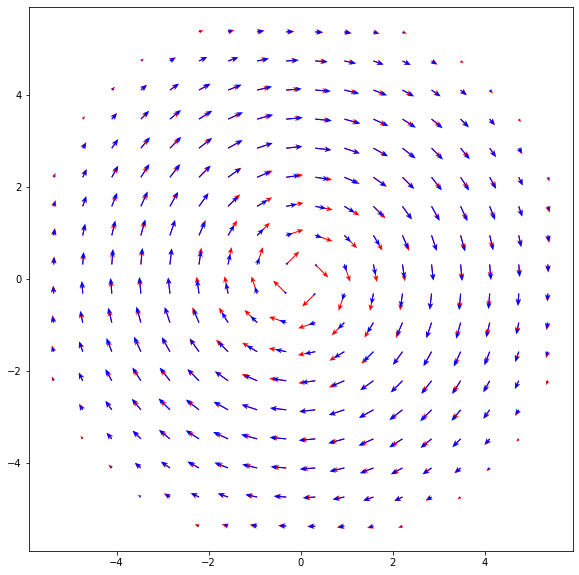

In [61]:
def fit_dr12(ngrid=20, rmax=6):
    
    xy = np.linspace(-rmax, rmax, ngrid)
    x, y = np.meshgrid(xy, xy)
    r = np.hypot(x, y)
    inside = r < rmax
    x = x[inside].reshape(-1)
    y = y[inside].reshape(-1)
    
    dx, dy = calib_errors_model(x, y, 0., 0., +5., -5., 3., 3.)
    
    coefs, fit_dx, fit_dy = fit_zhaoburge(x, y, dx, dy, np.ones_like(x), rmax, polids=range(31))
    print(coefs)
    
    fig, ax = plt.subplots(figsize=(10,10))
    Q = ax.quiver(x, y, dx, dy, angles='xy', scale=25. / 1., scale_units='xy',
                  headwidth=5, headlength=6, color='r', width=0.002)
    ax.quiver(x, y, fit_dx, fit_dy, angles='xy', scale=25. / 1., scale_units='xy',
              headwidth=5, headlength=6, color='b', width=0.002)
    ax.set(aspect=1)
    
fit_dr12()
# S11, S14

In [301]:
pos_id = 'M06939'
x, y, dx, dy, wgt = get_data(pos_id)
fit_calib_errors(pos_id, x, y, dx, dy, wgt)

Ignoring 30 / 6360 outlier moves
Ignoring 32 bins with <16 non-outlier moves


     fun: 8975060.149850946
 message: 'Optimization terminated successfully.'
    nfev: 452
     nit: 267
      r1: 3.0508
      r2: 3.0392
  status: 0
 success: True
       x: array([-7.49797194, -1.64608638,  8.14680612, -1.32782642])

In [302]:
fit_zhaoburge(x, y, dx, dy, wgt, rmax=6);

Plot all moves for a single robot. The two main options are:
 - binned: show residuals for all moves or the median residuals for binned moves (with at least min_count moves per bin)
 - subtract: show raw residuals or subtract the median or best-fit residual

In [303]:
def plot_one(pos_id, 
             M=All, fit_results=fit_results, outlier_nsig=4, subtract='fit', binned=True, min_count=16, summary='mean',
             what='data,model', ref=100, rmax=6, size=7.5, fit_model='zhaoburge', fit_rmax=6, save=None):

    loc = pos2loc[pos_id]
    x, y, dx, dy, wgt = get_data(pos_id, M, fit_results, outlier_nsig, subtract, binned, min_count, summary)
    
    fit = None
    what = what.split(',')
    if binned and ('model' in what or 'residual' in what):
        if fit_model == 'calib_errors':
            fit = fit_one(pos_id, x, y, dx, dy, wgt)
            if fit['success']:
                print(f'chisq / dof = {fit.fun / len(x):.2f}  params {np.round(fit.x, 3)}')
                fit_dx, fit_dy = distortion_model(x, y, *fit['x'], fit['r1'], fit['r2'])
            else:
                print('Fit failed:', fit['message'])
                return
        elif fit_model == 'zhaoburge':
            coefs, fit_dx, fit_dy = fit_zhaoburge(x, y, dx, dy, wgt, rmax=fit_rmax)
        else:
            print(f'Invalid fit_model "{fit_model}".')
            return
    else:
        what = ('data',)

    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    width = 0.002 if binned else 0.001
    Q = None
    norm = matplotlib.colors.Normalize(vmin=0., vmax=np.percentile(wgt, 95))
    if 'model' in what:
        Q = ax.quiver(x, y, fit_dx, fit_dy, angles='xy', scale=ref / 1., scale_units='xy',
                      headwidth=5, headlength=6, color='r', width=width)
    if 'residual' in what:
        Q = ax.quiver(x, y, dx - fit_dx, dy - fit_dy, wgt, norm=norm, angles='xy', scale=ref / 1., scale_units='xy',
                      headwidth=5, headlength=6, cmap='Blues', width=width)
    if 'data' in what:
        Q = ax.quiver(x, y, dx, dy, wgt, norm=norm, angles='xy', scale=ref / 1., scale_units='xy',
                      headwidth=5, headlength=6, cmap='Greys', width=width)
    ax.quiverkey(Q, X=0.90, Y=0.95, U=ref, label=f'{ref}μm', labelpos='S')
    ax.set(xlim=(-rmax,rmax), ylim=(-rmax,rmax), aspect=1,
           xlabel='Petal Δx [mm]', ylabel='Petal Δy [mm]')
    ax.text(0.02, 0.95, f'{pos_id}', fontsize=12, transform=ax.transAxes)
    ax.text(0.02, 0.90, f'loc {loc}', fontsize=12, transform=ax.transAxes)
    if fit_model == 'calib_errors':
        r1, r2, _ = r12s_by_loc[loc]
        dx0, dy0, dr1, dr2 = fit['x']
        ax.text(0.02, 0.06, f'Δx0 = {dx0:.1f}μm', fontsize=12, transform=ax.transAxes)
        ax.text(0.02, 0.02, f'Δy0 = {dy0:.1f}μm', fontsize=12, transform=ax.transAxes)
        ax.text(0.98, 0.06, f'r1 = {1e3*r1:.0f}{dr1:+.0f}μm', fontsize=12, transform=ax.transAxes, ha='right')
        ax.text(0.98, 0.02, f'r2 = {1e3*r2:.0f}{dr2:+.0f}μm', fontsize=12, transform=ax.transAxes, ha='right')

    ax.plot(0, 0, 'b+', ms=20)
    ax.add_artist(plt.Circle((0, 0), rmax, fc='none', ec='b', lw=1, ls='--'))
    plt.tight_layout()
    if save:
        plt.savefig()

Look at a random "good" robot:

Ignoring 72 / 6371 outlier moves


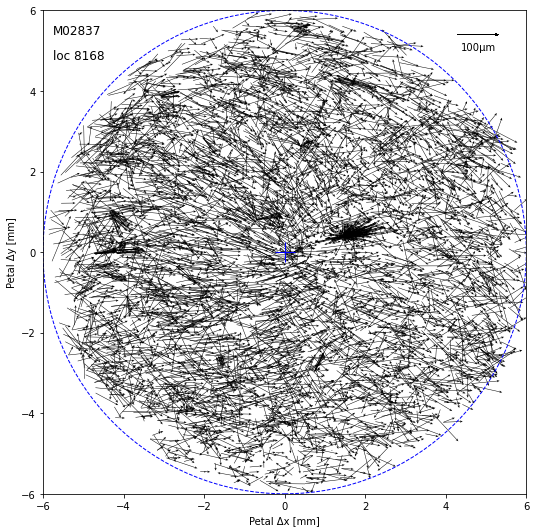

In [271]:
plot_one('M02837', binned=False, subtract='none')

Ignoring 163 / 6371 outlier moves


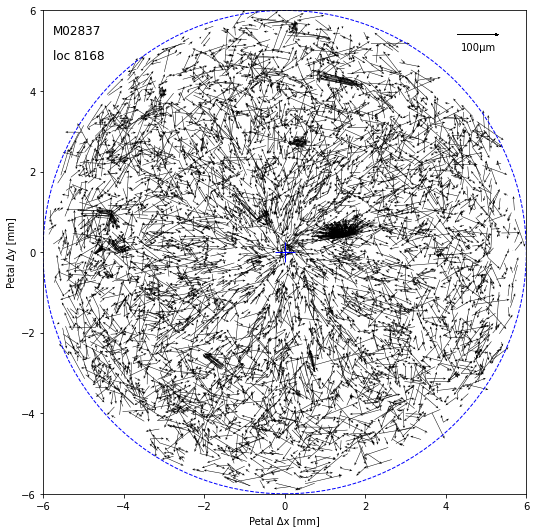

In [272]:
plot_one('M02837', binned=False, subtract='fit')

Ignoring 163 / 6371 outlier moves
Ignoring 30 bins with <16 non-outlier moves


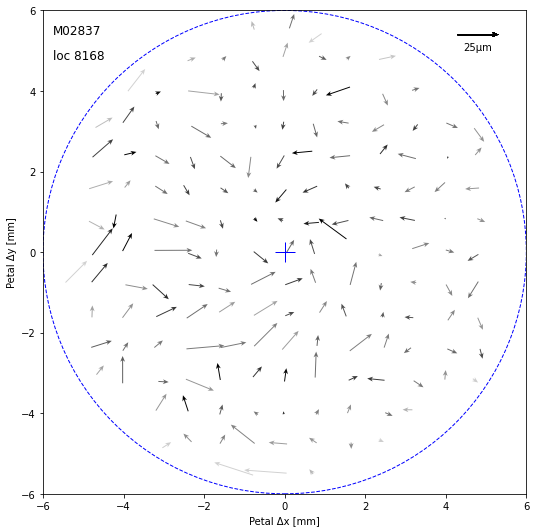

In [278]:
plot_one('M02837', binned=True, subtract='fit', what='data', ref=25)

Ignoring 163 / 6371 outlier moves
Ignoring 30 bins with <16 non-outlier moves


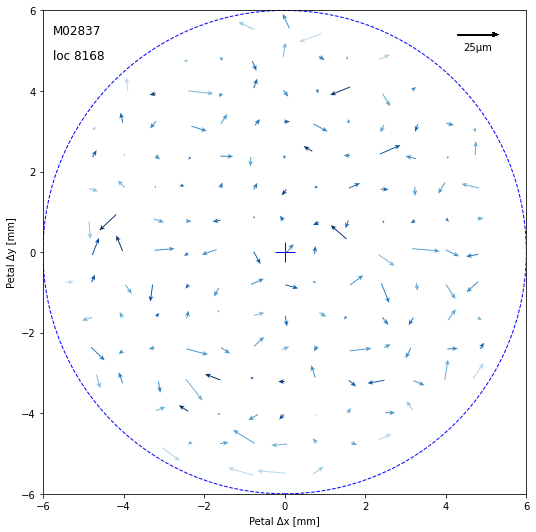

In [305]:
plot_one('M02837', binned=True, subtract='fit', what='residual', ref=25)

Ignoring 68 / 6240 outlier moves
Ignoring 29 bins with <16 non-outlier moves


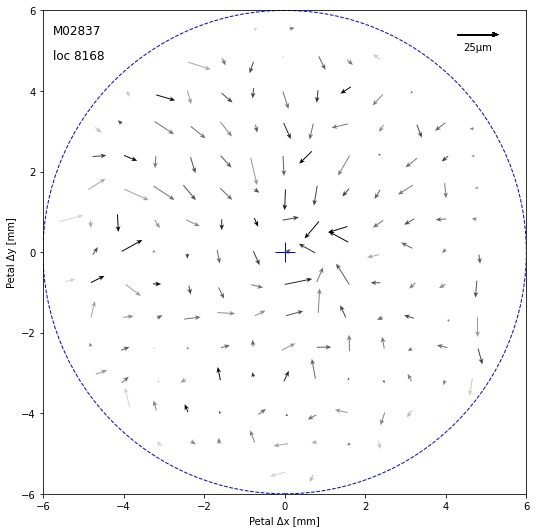

In [377]:
plot_one('M02837', binned=True, subtract='median', what='data', M=AllCorr, fit_results=fit_results_corr, ref=25)

Ignoring 68 / 6240 outlier moves
Ignoring 29 bins with <16 non-outlier moves


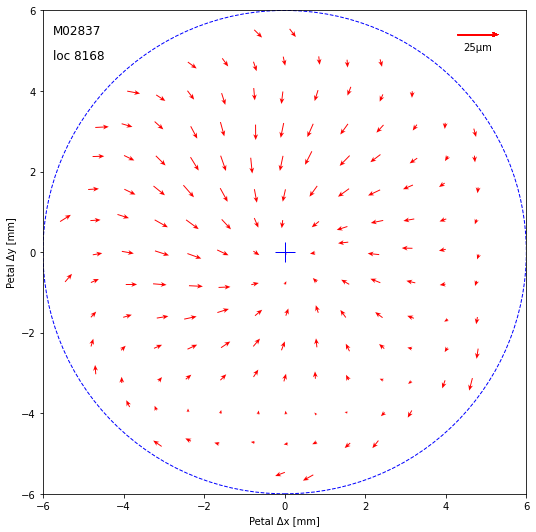

In [376]:
plot_one('M02837', binned=True, subtract='median', what='model', M=AllCorr, fit_results=fit_results_corr, ref=25)

Loop over and fit all robots:

In [310]:
def fit_all(M=All, fit_results=fit_results):
    
    results = { }
    for loc in sorted(M.location.unique()):
        pos_id = loc2pos[loc]
        x, y, dx, dy, wgt = get_data(pos_id, verbose=False)
        try:
            coefs, fit_dx, fit_dy = fit_zhaoburge(x, y, dx, dy, wgt, rmax=6)
        except Exception as e:
            print(f'Failed to fit {pos_id} loc {loc}: {e}')
            continue
        data_dr = np.hypot(dx, dy)
        residual_dr = np.hypot(dx - fit_dx, dy - fit_dy)
        dr1 = np.median(data_dr)
        dr2 = np.median(residual_dr)
        results[pos_id] = dict(loc=loc, dr1=dr1, dr2=dr2, coefs=coefs)
        
    return results

In [311]:
%time results = fit_all()

/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/

CPU times: user 7min 3s, sys: 4min 27s, total: 11min 30s
Wall time: 1min 51s


In [312]:
import json

In [313]:
class NumpyEncoder(json.JSONEncoder):
    """JSON encoder to use with numpy data with rounding of float32 values.
    """
    FLOAT32_DECIMALS = 6
    def default(self, obj):
        if isinstance(obj, np.float32):
            # Convert to 64-bit float before rounding.
            return float(np.round(np.float64(obj), self.FLOAT32_DECIMALS))
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.ndarray):
            if obj.dtype.fields is not None:
                # convert a recarray to a dictionary.
                new_obj = {}
                for (name, (dtype, size)) in obj.dtype.fields.items():
                    if dtype.base == np.float32:
                        new_obj[name] = np.round(obj[name], self.FLOAT32_DECIMALS)
                    else:
                        new_obj[name] = obj[name]
                return new_obj
            else:
                if obj.dtype == np.float32:
                    # tolist converts to 64-bit native float so apply rounding first.
                    obj = np.round(obj.astype(np.float64), self.FLOAT32_DECIMALS)
                return obj.tolist()
        else:
            return super().default(obj)

In [314]:
with open('fits.json', 'w') as f:
    json.dump(results, f, cls=NumpyEncoder)

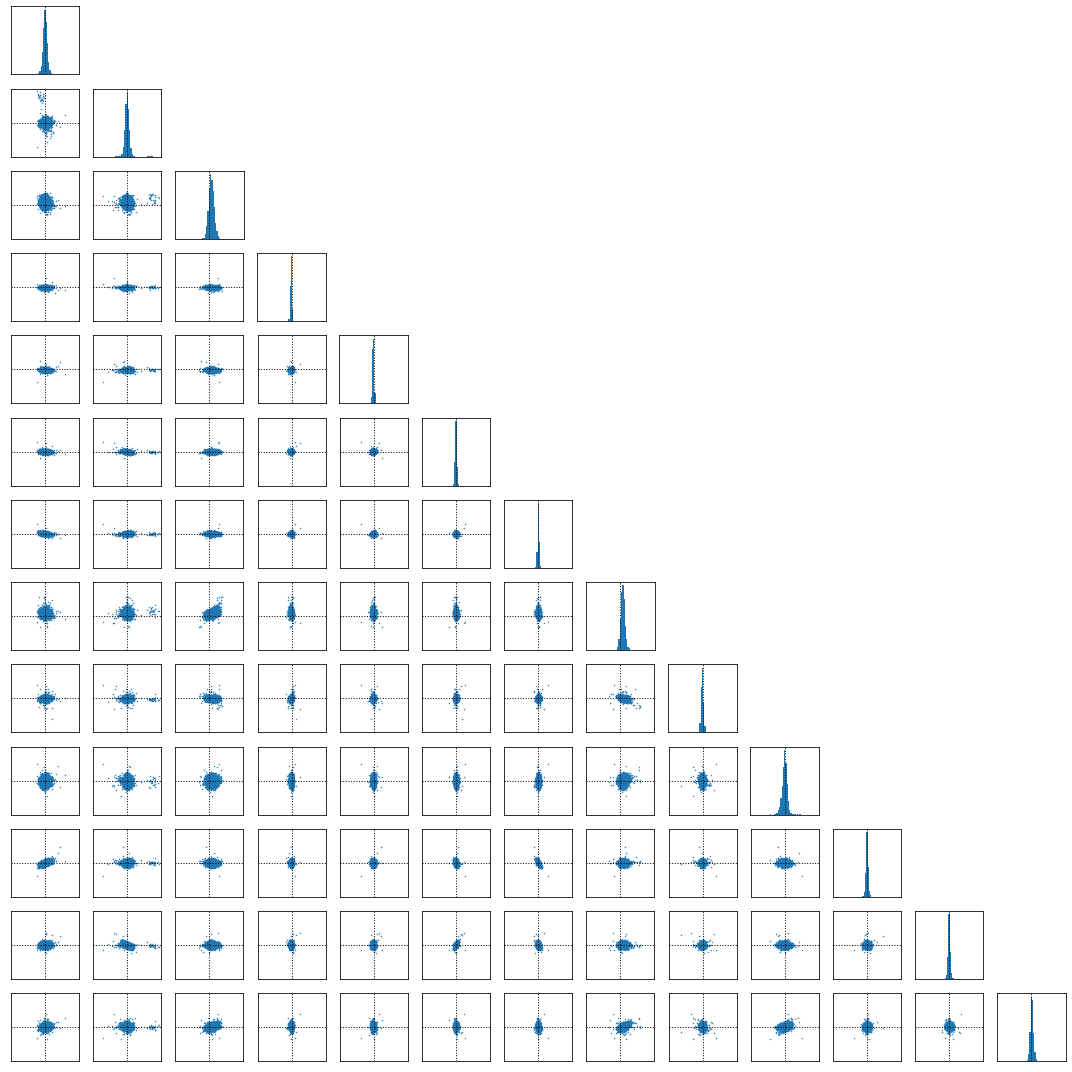

In [343]:
def plot_results(results=results, lim=60):

    nrobot = len(results)
    dr = np.zeros((nrobot, 2))
    ncoef = len(results['M02837']['coefs'])
    coefs = np.zeros((nrobot, ncoef))
    
    for k, (pos_id, info) in enumerate(results.items()):
        dr[k] = info['dr1'], info['dr2']
        coefs[k] = info['coefs']
    
    '''
    plt.plot(dr[:,0], dr[:,1], '.', ms=2)
    plt.grid()
    plt.show()
    '''
    bins = np.linspace(-lim, lim, 50)
    fig, axes = plt.subplots(ncoef, ncoef, figsize=(15,15))
    for i in range(0, ncoef):
        for j in range(ncoef):
            ax = axes[i,j]
            if j > i:
                ax.axis('off')
                continue
            if j == i:
                ax.hist(coefs[:,i], bins=bins)
                ax.set(xticks=[], yticks=[])
                ax.axvline(0, color='k', lw=1, ls=':')
                continue
            ax.plot(coefs[:,j], coefs[:,i], '.', ms=1)
            ax.set(aspect=1, xlim=(-lim,lim), ylim=(-lim,lim),xticks=[], yticks=[])
            ax.axvline(0, color='k', lw=1, ls=':')
            ax.axhline(0, color='k', lw=1, ls=':')
    plt.tight_layout()
    
plot_results()